# Car prices predictor

In this notebook, different tools from sklearn, numpy and panda were used
to create an algorithm capable of predicting a car´s price given some of it´s
information.

## Objectives:

* Analyze the data to get a good insight on it´s characteristics.
* Clean the data / get it readi to be fitted with a model.
* Find a Regression model that returns a **r2 of at least 0.9**  with our data and a 
  **porcentual absolute error below 12%**.
* How "heavy" the model is in terms of hardware requeriments will be considered.
* Analyze the performance of the best model achieved, using different metrics.

### Imports

In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# inline plots
%matplotlib inline

# models we´ll try
import sklearn
from sklearn.linear_model import ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# other necessary sklearn tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer

z9>1
520369+.ZA## Importing/Exploring the data

The analyzed data was taken from the following link.
https://www.kaggle.com/aleksandrglotov/car-prices-poland

In [15]:
data = pd.read_csv("CarPrices.csv")

In [16]:
# The rows seem to be ordered by mark and model
data.head()

,Unnamed: 0,mark,model,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


In [4]:
# Lets shuffle them to prevent unwanted patterns
data_shuffled = data.sample(frac=1)
data_shuffled

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
34601,34601,bmw,x5,gen-e53-1999-2006,2003,239000,4398,Gasoline,Siedlce,Mazowieckie,29900
35206,35206,volkswagen,arteon,NaN,2021,7000,1984,Gasoline,Włocławek,Kujawsko-pomorskie,189900
57116,57116,mercedes-benz,glc-klasa,NaN,2019,10000,1991,Gasoline,Staszów,Świętokrzyskie,220000
94882,94882,kia,ceed,gen-i-2006-2012,2009,152000,1396,Gasoline,Wołczyn,Opolskie,19700
33931,33931,bmw,x4,gen-f26-2014%E2%80%932018,2018,115000,2993,Diesel,Wrocław,Dolnośląskie,262000
...,...,...,...,...,...,...,...,...,...,...,...
15656,15656,audi,a4,gen-b8-2007-2015,2008,158000,1984,Gasoline,Stary Sącz,Małopolskie,32900
17696,17696,audi,a5,gen-8t-2007-2016,2010,212500,1984,Gasoline,Łódź,Łódzkie,42900
46016,46016,ford,c-max,gen-ii-2010-c-max,2011,215000,1560,Diesel,Dąbrowa Górnicza,Śląskie,29999
116050,116050,volvo,xc-60,gen-i-2008-2017,2012,238962,2400,Diesel,Warszawa,Mazowieckie,69900


In [5]:
# We have over 100.000 rows
data_shuffled.shape

(117927, 11)

In [6]:
# We have non numerical values, we´ll have to encode them
data_shuffled.dtypes

Unnamed: 0          int64
mark               object
model              object
generation_name    object
year                int64
mileage             int64
vol_engine          int64
fuel               object
city               object
province           object
price               int64
dtype: object

In [7]:
# 30% of the generation_name column values are NaNs, we´ll just drop that one later.
data_shuffled.isna().sum()

Unnamed: 0             0
mark                   0
model                  0
generation_name    30085
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64

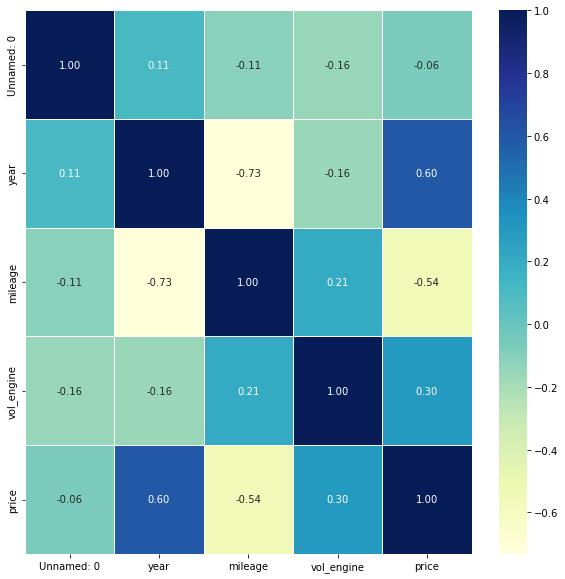

In [8]:
# Generation matrix: Besides unnamed0, all numerical columns seem important.
corr_matrix = data_shuffled.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_matrix, 
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

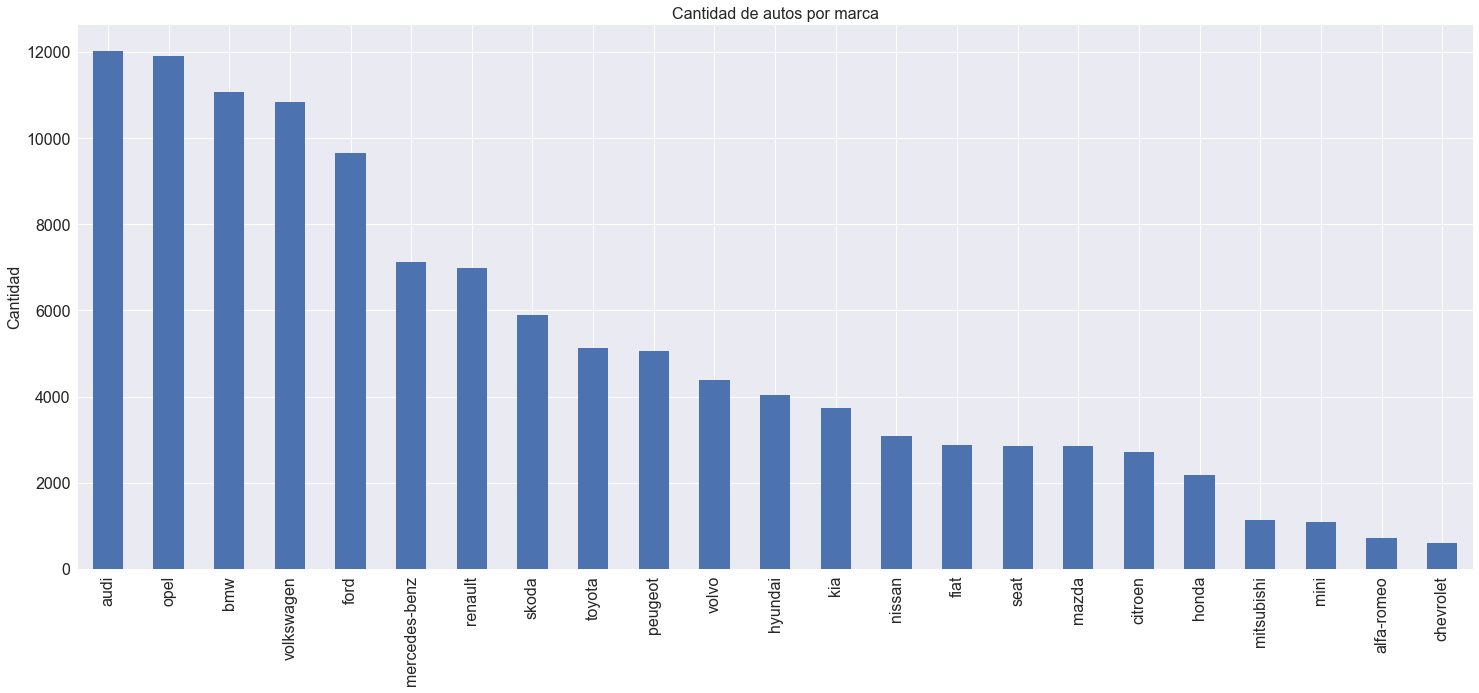

In [9]:
# Let´s see the distribution by mark.

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(25, 10))

ax = data_shuffled["mark"].value_counts().plot(kind="bar")
ax.set_ylabel("Cantidad", fontsize=16)
ax.set_title("Cantidad de autos por marca", fontsize=16)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(16)

## Preprocessing

In [10]:
# First i´ll drop some columnes that are irrelevant when it comes to predicting the price
data_shuffled_drop = data_shuffled.drop(["city",
                                         "province", 
                                         "generation_name", 
                                         "Unnamed: 0"],
                                         axis=1
                                        )
data_shuffled_drop.shape
data_shuffled_drop.head()

In [11]:
# Let´s split the data in atributes and targets
X = data_shuffled_drop.drop("price", axis=1)
y = data_shuffled_drop["price"]

# I´ll codify the not numerical columns
X = pd.get_dummies(X)
X.head()

,year,mileage,vol_engine,mark_alfa-romeo,mark_audi,mark_bmw,mark_chevrolet,mark_citroen,mark_fiat,mark_ford,...,model_yaris,model_yeti,model_zafira,model_zoe,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_Gasoline,fuel_Hybrid,fuel_LPG
34601,2003,239000,4398,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
35206,2021,7000,1984,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
57116,2019,10000,1991,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
94882,2009,152000,1396,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
33931,2018,115000,2993,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
# We get 360 columns, becouse of the amount of car marks. Still, i´ll preserve that data, it´s important.

print(X.shape)
print("There are:", len(data_shuffled_drop["model"].value_counts()), "diferent car marks in the data")

(117927, 360)
There are: 328 diferent car marks in the data


In [13]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(94341, 360)
(94341,)
(23586, 360)
(23586,)


# Modeling

The used models were selected using the map in the folowing link.
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Used models: 

* RandomForestRegressor (ensemble)
* GradientBoostingRegressor (ensemble)

In [14]:
# Let´s instanciate the models

RFR = RandomForestRegressor()
GBR = GradientBoostingRegressor()

In [ ]:
np.random.seed(42)

# A quick test
RFR.fit(X_train, y_train)
print("RandomForest:", RFR.score(X_test, y_test))

GBR.fit(X_train, y_train)
print("GradientBoost:", GBR.score(X_test, y_test))

RandomForest: 0.9361038039466358


RFR got the highes r2, let´s see wich one is the fastest when it comes to predicting.

In [ ]:
%timeit RFR.score(X_test, y_test)

In [ ]:
%timeit GBR.score(X_test, y_test)

Gradient boost is way faster

Let´s cross validate the models to have a more solid idea of their performance in our data

In [ ]:
#Para RandomForest
np.random.seed(42)
cv_acc_RFR = cross_val_score (RFR,
                              X_train,
                              y_train, cv=5,
                              verbose = 10,
                              scoring = "r2", 
                              n_jobs=-1)
np.mean(cv_acc_RFR)

In [ ]:
# Para GradientBoosting
np.random.seed(42)
cv_acc_GradBoost = cross_val_score (GBR, 
                                    X_train,
                                    y_train, cv=5,
                                    verbose = 10,
                                    scoring = "r2",
                                    n_jobs=-1)
np.mean(cv_acc_GradBoost)

Random forest is still superior, i´ll choose it as my model.


In the next section i´ll tune RandomForestRegressor hyperparámeters.

# Hyperparámeter tuning: Random Forest Regressor

In [ ]:
# Let´s remember the model´s hyperparameters
RFR.get_params()

In [ ]:
# A grid with the hyperparameters we´ll try

RFR_grid = {'bootstrap': [True, False],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [100]}

The next cell takes a lot of time to be executed!

In [ ]:
"""
rs_RFR = RandomizedSearchCV(estimator=RFR,
                            param_distributions=RFR_grid,
                            n_iter=10, 
                            cv=4, 
                            verbose=10,
                            n_jobs = -1)

rs_RFR.fit(X_train, y_train)

# These are the best hyperparámeters found
rs_RFR.best_params_"""

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'bootstrap': True}

Let´s create an instance of RandomForestRegressor with the best hyperparámeters found, and test it using cross validation

In [ ]:
RFR_bp = RandomForestRegressor (n_estimators= 200,
                                min_samples_split= 5,
                                min_samples_leaf= 1,
                                bootstrap= True)

cv_acc_RFR_bp = cross_val_score (RFR_bp,
                                 X,
                                 y, 
                                 cv=5,
                                 verbose = 10,
                                 scoring = "r2", 
                                 n_jobs=-1)
np.mean(cv_acc_RFR_bp)

Note: I also tried tuning GradientBoosting hyperparámeters, but i did´nt get any improvment. 


# Evaluating the model (RandomForest):

The metrics we´ll use to evaluate the model are:

* R2 (again in these section for completeness)
* mean absolute error
* mean percentual error

In [ ]:
#RFR best params
RFR_bp = RandomForestRegressor(n_estimators = 150)

In [ ]:
cv_r2 = cross_val_score(RFR_bp, 
                         X, 
                         y, 
                         cv=4, 
                         verbose = 1,
                         scoring="r2",
                         n_jobs = -1)

print(f"RandomForest r2: {np.mean(cv_r2):.2f}")

In [ ]:
cv_mae = cross_val_score(RFR_bp, 
                         X, 
                         y, 
                         cv=4, 
                         verbose = 1,
                         scoring="neg_mean_absolute_error",
                         n_jobs = -1)

print(f"RandomForest MAE: {-np.mean(cv_mae):.2f}")

In [ ]:
cv_mape = cross_val_score(RFR_bp, 
                         X, 
                         y, 
                         cv=4, 
                         verbose = 0,
                         scoring="neg_mean_absolute_percentage_error",
                         n_jobs = -1)

print(f"RandomForest MPE: {-np.mean(cv_mape):.2f}")